# Model Explainability in Computer Vision with Grad-CAM

This notebook implements **GradCAM** and at least **two variants** on a small image classification task to analyze what regions a pretrained model attends to.  

---


## 1) Setup

In [2]:

# If running in a new environment, uncomment and run the next cell to install dependencies.
# There is more than one way to skin a cow, so you can this command using pip as option in a python command or just use the pip command below.
# If your intent is just ro un this project, take the path of least resistance and just run it on Colab. Link provided in the README.
%pip install torch torchvision timm grad-cam matplotlib opencv-python numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=f495b0bffea44fd8e256b02fa6d9ae034f4e2bd077e654fee4ac425d4455effc
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [3]:

import os, random, json, time, math, pathlib
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm

import matplotlib.pyplot as plt
import cv2

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'


## 2) Choose a Task & Dataset

We'll do **Recycling Sorting** (environmental sustainability): classify images as types of recyclable items (e.g., *plastic*, *paper*, *metal*).  

**Option A (Recommended):** Use your own small dataset in an `ImageFolder` directory structure. Make sure you have your folders with the images or this project won't work. Alterntively used the images that I already have here in the folder. When I was going to submit the assignment I added the images locally. If this is the path you choose, no further action is required. I submitted this code to GitHub in a way that you just need to set up the project and run it:

```
data/recycling/
  plastic/
     img1.jpg
     img2.jpg
  paper/
     img3.jpg
  metal/
     img4.jpg
```

Put at least **5–10 images total** across 2–3 classes (you can use your phone or royalty‑free images). The option B below is just to make sure that you have a fool proof way to run the project. If you don't have a folder or misspelled it, it will fall on a dummy array of data to run the project.

**Option B (Fallback demo, just an alternative to make sure things run):** If you don't have a recycling folder, we'll automatically use **CIFAR‑10** and map categories to a pseudo‑recycling problem (not perfect, but it demonstrates the methods). It uses a small data structure and the logic is found on the else block below.


In [4]:

DATA_DIR = pathlib.Path("data/recycling")

IMG_SIZE = 224
BATCH_SIZE = 1

common_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

def load_imagefolder_dataset(path: pathlib.Path):
    ds = ImageFolder(str(path), transform=common_tfms)
    classes = ds.classes
    return ds, classes

def load_cifar10_demo():
    tfms = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])
    ds = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=tfms)
    # Below is the fall back data structure that I mentioned in the intro to this section.
    class_map = {
        0: "airplane->metal",
        1: "automobile->metal",
        2: "bird->paper",
        3: "cat->paper",
        4: "deer->paper",
        5: "dog->paper",
        6: "frog->organic",
        7: "horse->paper",
        8: "ship->metal",
        9: "truck->metal",
    }
    return ds, class_map

use_imagefolder = DATA_DIR.exists() and any(DATA_DIR.iterdir())
if use_imagefolder:
    dataset, class_names = load_imagefolder_dataset(DATA_DIR)
    print(f"Loaded custom dataset from {DATA_DIR}. Classes: {class_names}")
else:
    dataset, class_map = load_cifar10_demo()
    print("Using CIFAR-10 fallback demo (not a true recycling dataset).")
    print("Class mapping example:", {k: class_map[k] for k in sorted(class_map)[:5]})

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 170M/170M [00:02<00:00, 61.8MB/s]


Using CIFAR-10 fallback demo (not a true recycling dataset).
Class mapping example: {0: 'airplane->metal', 1: 'automobile->metal', 2: 'bird->paper', 3: 'cat->paper', 4: 'deer->paper'}


## 3) Load a Pretrained Model

In [5]:

# We'll use a robust ImageNet-pretrained model.
model_name = "resnet50"
model = timm.create_model(model_name, pretrained=True).to(device).eval()

# Identify the final convolutional block for CAM
# For ResNet50, this is layer4[-1]
target_layers = [model.layer4[-1]]
print("Model loaded:", model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model loaded: resnet50


## 4) Utilities for Visualization & Prediction

In [6]:

def tensor_to_rgb_img(t):
    arr = t.detach().cpu().numpy()
    if arr.ndim == 4:
        arr = arr[0]
    arr = np.transpose(arr, (1,2,0))
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    return arr

def predict_topk(model, x, k=5):
    with torch.no_grad():
        logits = model(x.to(device))
        probs = torch.softmax(logits, dim=1)
        topk = torch.topk(probs, k, dim=1)
    return topk.indices[0].cpu().tolist(), topk.values[0].cpu().tolist()

def show_image_with_title(img_tensor, title=""):
    rgb = tensor_to_rgb_img(img_tensor)
    plt.figure(figsize=(4,4))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(title)
    plt.show()


## 5) Grad-CAM and Variants

In [8]:

# Define CAM methods
cam_methods = {
    "GradCAM":       GradCAM(model=model, target_layers=target_layers),
    "GradCAM++":     GradCAMPlusPlus(model=model, target_layers=target_layers),
    "ScoreCAM":      ScoreCAM(model=model, target_layers=target_layers),
    "EigenCAM":      EigenCAM(model=model, target_layers=target_layers),
}

list(cam_methods.keys())


['GradCAM', 'GradCAM++', 'ScoreCAM', 'EigenCAM']

## 6) Run on ≥5 Images and Generate Visualizations

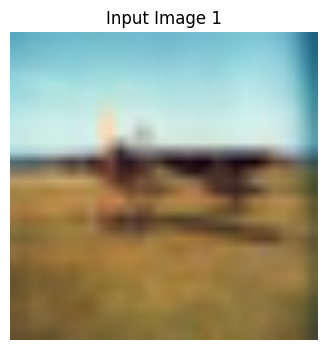

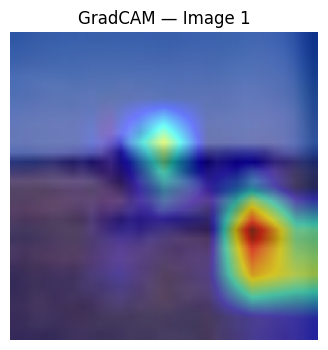

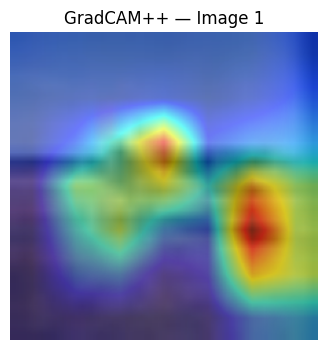

100%|██████████| 128/128 [08:01<00:00,  3.76s/it]


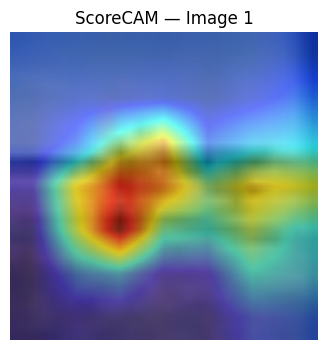

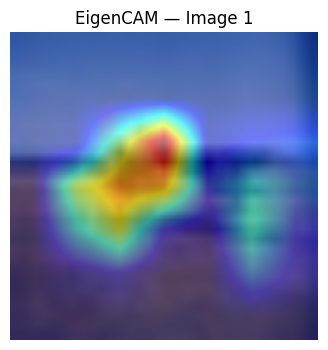

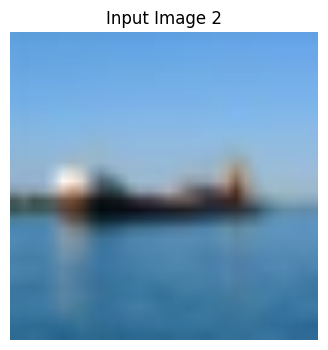

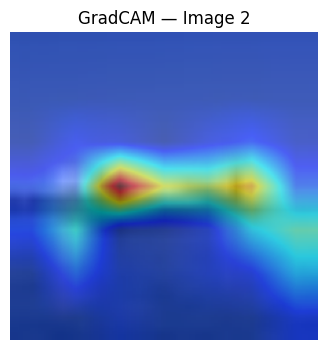

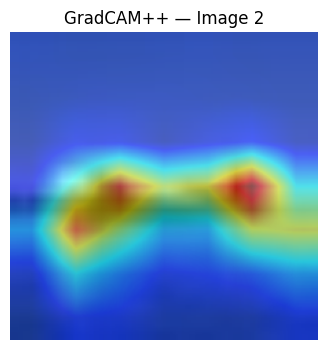

100%|██████████| 128/128 [07:48<00:00,  3.66s/it]


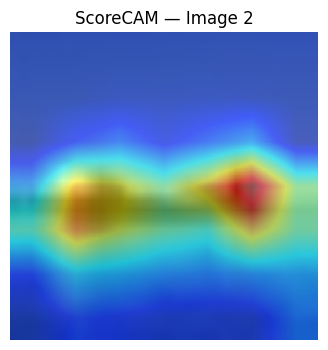

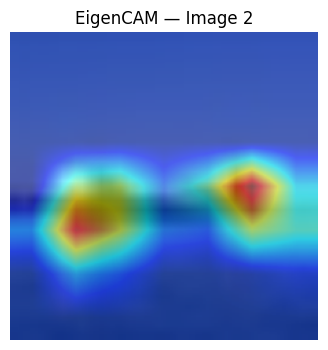

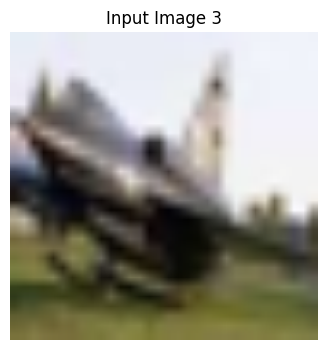

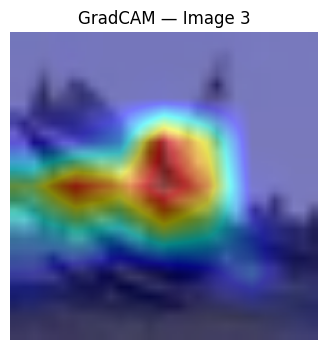

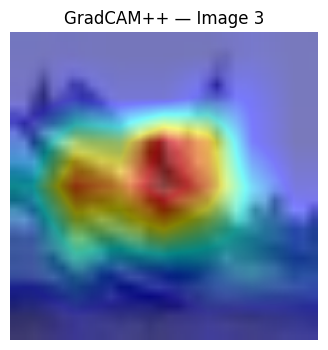

100%|██████████| 128/128 [06:27<00:00,  3.03s/it]


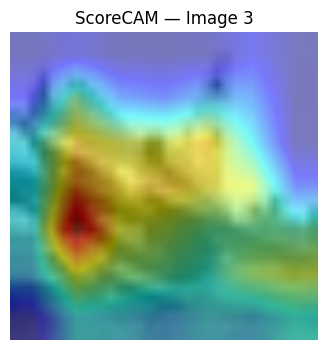

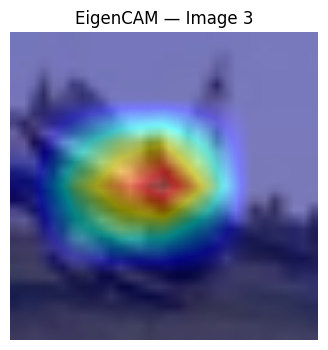

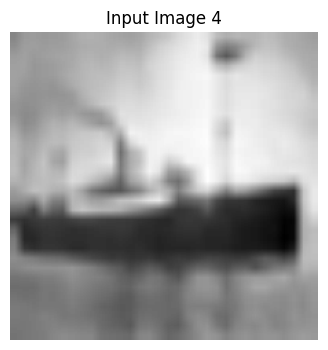

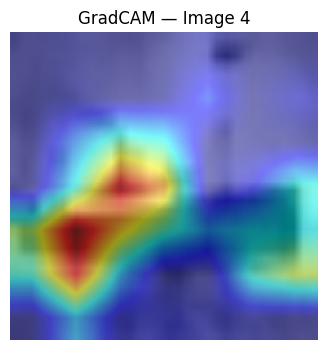

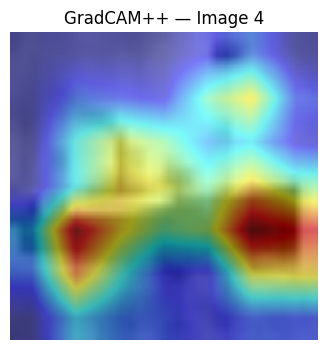

100%|██████████| 128/128 [06:26<00:00,  3.02s/it]


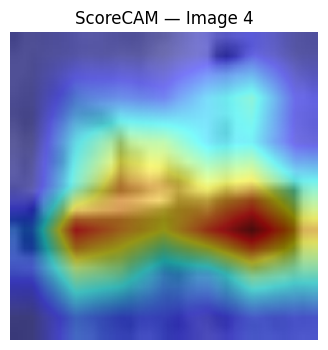

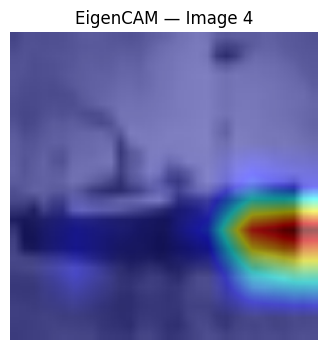

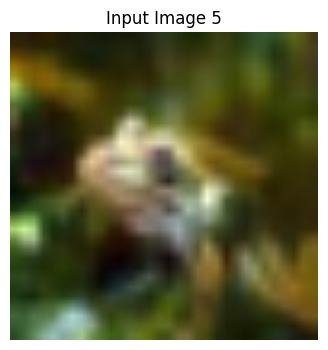

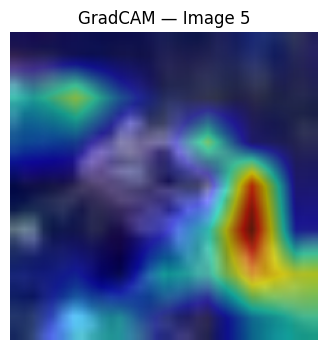

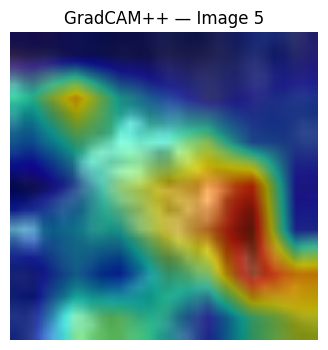

100%|██████████| 128/128 [06:54<00:00,  3.24s/it]


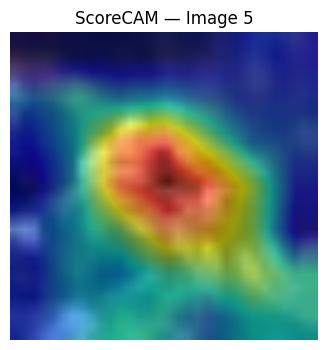

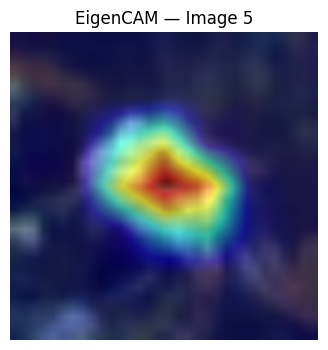

Completed CAM visualizations for 5 images.


In [9]:

NUM_IMAGES = 5  # adjust if we want more. If you added 10 images, use 10.
results = []

for idx, (img, label) in enumerate(loader):
    if idx >= NUM_IMAGES: break
    img = img.to(device)
    # Prediction
    top_idxs, top_probs = predict_topk(model, img, k=3)
    pred_info = list(zip(top_idxs, [float(p) for p in top_probs]))

    # Build CAM targets (use predicted top-1 class for visualization)
    targets = [ClassifierOutputTarget(top_idxs[0])]

    rgb_img = tensor_to_rgb_img(img)
    show_image_with_title(img, title=f"Input Image {idx+1}")

    per_image = {"index": idx, "pred_topk": pred_info, "cams": {}}
    for name, cam in cam_methods.items():
        grayscale_cam = cam(input_tensor=img, targets=targets)[0]
        vis = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        per_image["cams"][name] = grayscale_cam

        plt.figure(figsize=(4,4))
        plt.imshow(vis)
        plt.axis('off')
        plt.title(f"{name} — Image {idx+1}")
        plt.show()
    results.append(per_image)

print("Completed CAM visualizations for", len(results), "images.")



## 7) Comparative Analysis (Write-up)

For each image, compare **GradCAM**, **GradCAM++**, **ScoreCAM**, and **EigenCAM**:

- **Localization & sharpness:** Which method produced the most focused attention on the true object?
- **Stability:** Is one method more consistent across images?
- **Failure modes:** Any method highlighting background or text instead of the object?
- **Class sensitivity:** Did any method change drastically if you set the target to the ground-truth class vs. the model’s predicted class?

Use the space below to add your observations.



### Notes / Observations
- Image 1: _your notes here_
- Image 2: _your notes here_
- Image 3: _your notes here_
- Image 4: _your notes here_
- Image 5: _your notes here_



## 8) Reflection

- **Visual cues the model attends to:** What consistent patterns did you observe? Did the model focus on shape, texture, backgrounds, or brand logos?
- **Surprising or misleading behavior:** Document at least one example where the heatmap attention did not align with the object of interest.
- **Why explainability matters in recycling:** In sustainability tasks, explainability builds trust that models aren’t keying off spurious correlations (e.g., studio background instead of material type). It also helps guide data collection (diversity of lighting, backgrounds, containers).

_Add 1–2 paragraphs summarizing your reflections._



## 9) Conclusion & Next Steps
- **Summary:** Which CAM method do you find most reliable for this task and why?
- **Limitations:** Small dataset size, potential dataset bias, coarse localization of CAMs.
- **Future work:** Try more images, add proper recycling dataset (e.g., TrashNet/Kaggle Recycle), evaluate quantitative metrics (pointing game, deletion/insertion), and test other models (ViT).
